
#                                                   THE POD-I METHOD
 Script by Elise Grosjean (ENSTA-Paris, elise.grosjean@ensta-paris.fr)

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-fem
!{sys.executable} -m pip install scikit-learn

Let us consider a parameterized problem. Having (previously computed) solutions for different parameter values, we aim at approaching much faster the solution associated to a new parameter value.
The Galerkin-Proper Orthogonal Decomposition (POD) algorithm is decomposed in two parts: 
- The "offline part" : First we compute a reduced basis (denoted $\Phi_i$ for $i=1,\dots,N$) from several training snapshots of the solution (solutions for different parameter values in a parameter set $\mathcal{G}$) through a POD procedure.

  Then, a further step is added. It consists in computing the reduced coefficients for all snapshots within the training set of parameters $\mathcal{G}_{Ntrain} \subset \mathcal{G}$.                                                    We denote by $\alpha_i(\mu_k),i = 1,...,N, k = 1,...,Ntrain$ these coefficients. We obtain $Ntrain$ pairs $(\mu_k,\alpha (\mu_k))$, where $\alpha(\mu_k) \in \mathbb{R}^N$.                                                           
Thanks to an interpolation/regression, the function that maps the input parameters $\mu_k$ to the coefficients can be reconstructed.                                                                                              
- The "online part" : then instead of projecting onto the reduced space the solution associated to the new parameter value that we are interested in, denoted by $\mu \in \mathcal{G}$, we employ the interpolation/regression during the online stage to find the interpolated new coefficients for $\mu \in \mathcal{G}$.

Different methods of interpolation might be employed (in this notebook we use a regression with the scikit-learn package).


In [1]:
# import packages
import skfem  # for Finite Element Method
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## 1) The 2D-driven cavity problem:
#
We are going to use in this example the famous 2D-driven cavity problem with the Finite Element Method (FEM), which consists in 
solving on a unit square (denoted $\Omega$) the following equations:
\begin{align}
&-\nu \Delta u + (u \cdot \nabla) u + \nabla p =0, \textrm{ in } \Omega,\\
& \nabla. u=0, \textrm{ in } \Omega,\\
& (u_1,u_2)=(1,0), \textrm{ on } \Omega_{up}:=\partial \Omega \cap \{y=1\},\\
& (u_1,u_2)=(0,0), \textrm{ on } \partial \Omega \backslash \Omega_{up},
\end{align}
where $u=(u_1,u_2) \in V:=H^1_{d,0}(\Omega)^2=\{u \in H^1(\Omega)^2, \gamma_{\partial \Omega \backslash \Omega_{up}} u=0, \ \gamma_{up} u =(1,0) \}$ ($\gamma$ stands for the trace operator) represents the velocity of the incompressible fluid, $ p \in L^2(\Omega)$ its pressure, and $\nu=\frac{1}{Re}$ where $Re$ is the Reynolds parameter. Here, the Reynolds number is our parameter of interest ($\mu=Re$).
For the nonlinearity we adopt a fixed-point iteration scheme, and after multiplying by test functions $q$ and $v$ (resp. for pressure and velocity), which in variational form reads:
\begin{equation}
\nu (\nabla u^k, \nabla v) + ((u^{k-1} \cdot \nabla) u^k,v) -  (p^k, \nabla \cdot v) - (q, \nabla \cdot u^k) + 10^{-10} (p^k, q) =0, \textrm{in } \Omega,
\end{equation}
where $u^{k-1}$ is the previous step solution, and we iterate until a threshold is reached (until $\|u^{k}-u^{k-1}\| < \varepsilon $).
Here, with the term $ 10^{-10} (p^k, q)  $, we impose the average of the pressure $\int_{\Omega} p^k $ to be equal to $0$. For more details on how we derive this formulation, visit the link : https://github.com/grosjean1/navierStokes (FEM.pdf).

We employ Taylor-Hood elements to get a proper solution (e.g. P2-P1 for the tuple velocity-pressure) and obtain the system $\mathbf{K} \mathbf{x} =\mathbf{f}$ to solve where $\mathbf{K}= \begin{pmatrix}
\mathbf{A} & -\mathbf{B}^T\\
-\mathbf{B} & 10^{-10} \mathbf{C}
\end{pmatrix}$, $\mathbf{x}$ stands for the tuple velocity-pressure $(u_1^k,u_2^k,p^k)$, and where the assembled matrix $\mathbf{A}$ corresponds to the bilinear part $ \nu (\nabla u^k, \nabla v) + ((u^{k-1} \cdot \nabla) u^k),v) $, the matrix $ B$ to the bilinear part $(  p^k ,\nabla \cdot v)$ and $\mathbf{C}$ is the mass matrix applied to the pressure variable ($(\cdot,\cdot)$ represents either the $L^2$ inner-product onto the velocity space or onto the pressure space). 


The dirichlet boundary conditions are imposed with a penalization method, called with scikit-FEM by the line: 

solve(*condense(K,f, x=uvp, D=D)),

where x=uvp gives the values at the boundaries of the velocity and D refers to the boundary decomposition.




<skfem MeshTri1 object>
  Number of elements: 2048
  Number of vertices: 1089
  Number of nodes: 1089
  Named boundaries [# facets]: left [32], bottom [32], right [32], top [32], down [32], up [32]


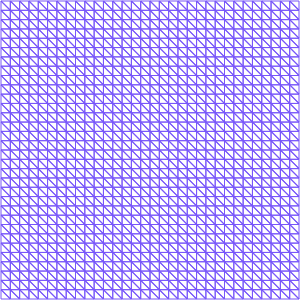

In [2]:
""" First we define a mesh for the unit square with the boundary decomposition """
mesh= skfem.MeshTri().refined(5).with_boundaries(
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

print(mesh)
mesh


In [3]:
""" Then we assemble the matrices of our model problem """

# Assembling matrices

from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import grad, dot,div,ddot

@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))

@BilinearForm
def vector_laplace(u, v, w):
    # same as laplace but for u,v vectors 
    return w.nu*ddot(grad(u), grad(v))

@BilinearForm
def mass(u, v, _):
    return u * v

@BilinearForm
def divu(u, v, w):
    return div(u) * v

@BilinearForm
def nonlinearterm(u, v, w):
    up_x, up_y = w.up 
    v_x,v_y=v[0],v[1]
    
    gradu=grad(u)
    gradxu_x=gradu[0,0] 
    gradxu_y=gradu[0,1]
    gradyu_x=gradu[1,0]
    gradyu_y=gradu[1,1]
    
    return (up_x*gradxu_x+up_y*gradxu_y)*v_x + (up_x*gradyu_x+up_y*gradyu_y)*v_y
    

In the 2D-driven cavity problem, the parameter of interest is the Reynolds number. In the code bellow, the function SolveCavityProblem(Re,Mesh) takes as parameters the Reynolds number and a mesh, and returns the associated solution (velocity-pressure).

In [4]:
""" Finally we solve the problem """
from skfem import *
# Compute solution of the 2d-driven cavity problem
element = {'u': ElementVector(ElementTriP2()),
           'p': ElementTriP1()} #[u,v,p]= velocity-pressure with Taylor-Hood P2-P1 FEM elements


def SolveCavityProblem(Re,Mesh):
    # Re is the reynolds parameter #
    Nu=1./Re 
    print('Parameter nu:',Nu)

    basis = {variable: Basis(Mesh, e, intorder=4)
         for variable, e in element.items()} # FEM space
    up=basis['u'].zeros() #initialization for non-linear term previous solution
    
    B =divu.assemble( basis['u'], basis['p']) # B.T=p*div(v) and B=q *div(u) with q=pressure test function
    C = mass.assemble(basis['p'],basis['p'] ) # 1^-10 * p*q impose pressure average equal to 0.
    A1 =vector_laplace.assemble(basis['u'],nu=Nu) # nu* grad(u) * grad(v) with u=[u1,u2] and v is test function v=[v1,v2]
    #A2=nonlinearterm.assemble(basis['u'],up=basis['u'].interpolate(up)) #(u^(k-1). grad u^k). v


    # global matrix Stokes
    K = bmat([[A1, -B.T],
          [-B, 1e-10 * C]], 'csr')

    def profil_up(x):
        """return u=(0,1) at the up boundary and (0,0) otherwise """
        return np.stack([x[1]==1, np.zeros_like(x[0])])
    
    up_basis = FacetBasis(Mesh, element['u'], facets=Mesh.boundaries['up'])
    all_basis = FacetBasis(Mesh, element['u'])

    uvp_boundary = np.hstack((
        all_basis.project(profil_up), # can be replaced by all_basis.project(profil_up), will be 0 by default for the other boundaries
        basis['p'].zeros(),
    ))

    D = basis['u'].get_dofs(['up', 'down', 'right','left']) # since we put D on basis['u'], there will be no penalization on pressure
    f = np.concatenate([basis['u'].zeros(),basis['p'].zeros()]) # =0

    #######################
    ### SOLVING PROBLEM ###
    #######################
    uvp = solve(*condense(K,f, x=uvp_boundary, D=D))
    velocity, pressure = np.split(uvp, K.blocks)

    for i in range(15): #fixed-point algorithm
        up=velocity.copy() # updating velocity
        A2=nonlinearterm.assemble(basis['u'],up=basis['u'].interpolate(up))

     
        # global matrix assembling update
        K = bmat([[A1+A2, -B.T],
          [-B, 1e-10 * C]], 'csr')

        uvp = solve(*condense(K,f, x=uvp_boundary, D=D))
     
        velocity, pressure = np.split(uvp, K.blocks)

    return velocity,pressure
    


Parameter nu: 0.006666666666666667


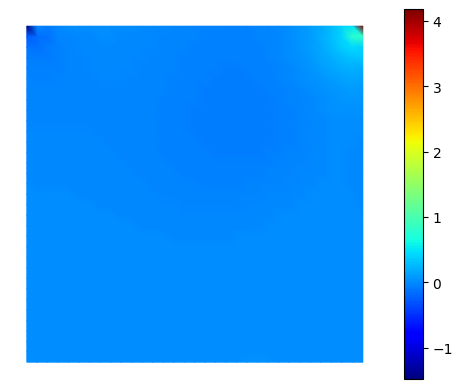

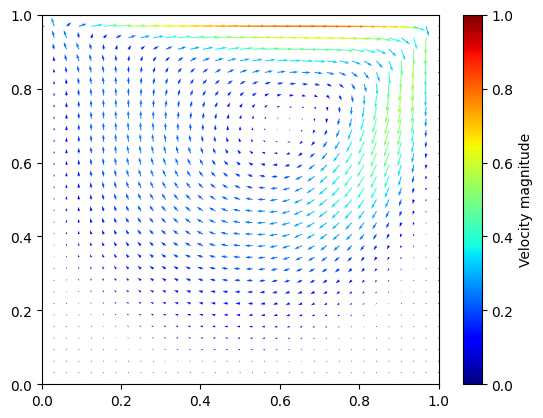

In [5]:
""" We can visualize the solutions """

from skfem.visuals.matplotlib import plot, draw, savefig

velocity,pressure=SolveCavityProblem(150,mesh) 

def visualize_pressure(Mesh,Pressure):
    ## Function that allows us to visualize the pressure
    return plot(Mesh, Pressure, shading='gouraud', colorbar=True)
    
visualize_pressure(mesh,pressure).show()

def visualize_velocity(Mesh,Velocity):
    ## Function that allows us to visualize the velocity
    fig, ax = plt.subplots()

    # Calculate the magnitude of velocity
    basis = {variable: Basis(Mesh, e, intorder=4)
            for variable, e in element.items()} # FEM space
    velocity1 = Velocity[basis['u'].nodal_dofs].copy()
    magnitude = np.sqrt(velocity1[0]**2 + velocity1[1]**2)

    # Display the velocity fields with colors for magnitude
    quiver = ax.quiver(*Mesh.p, *velocity1, magnitude, angles='xy', cmap='jet')

    # colorbar
    cbar = plt.colorbar(quiver, ax=ax)

    # Limits of axis for the mesh
    ax.set_xlim([Mesh.p[0].min(), Mesh.p[0].max()])
    ax.set_ylim([Mesh.p[1].min(), Mesh.p[1].max()])
    cbar.set_label('Velocity magnitude')
    # show results
    plt.show()

visualize_velocity(mesh,velocity)

## 2) The POD-I method

We are now able to proceed with the offline and online parts of the PODI method.


#### OFFLINE PART


We define one mesh and the associated finite element spaces (as before).

In [6]:
## FINE MESH
FineMesh = skfem.MeshTri().refined(5).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

FineBasis = {variable: Basis(FineMesh, e, intorder=4)
            for variable, e in element.items()} # FEM space

NumberOfNodesFineMesh = FineMesh.p.shape[1]
print("number of nodes: ",NumberOfNodesFineMesh)
#num_dofs_uFineMesh = basis['u'].doflocs.shape[1] # or np.shape(velocity)[0] for DOFs


number of nodes:  1089


As in the POD-Galerkin, we decompose the snapshots by one average over the parameters $\overline{u}$ and by one fluctuation part $u_f$. Then, the POD modes are estimated with the fluctuations following the steps detailed in the paragraph on the POD introduction.

In [7]:
""" POD """

print("-----------------------------------")
print("        Offline                    ")
print("-----------------------------------")

NumberOfSnapshots=25
NumberOfModes=4 

print("number of modes: ",NumberOfModes)

#####  Create fluctuation parts for the snapshots #####
Re=1. #first Reynolds number
AveragedSnapshots=FineBasis["u"].zeros()

FineSnapshots=[]
Parameters = np.zeros(NumberOfSnapshots) #dimension of parameter=1
for i in range(NumberOfSnapshots):
    
    velocity,pressure=SolveCavityProblem(Re,FineMesh)
    print(Re)
    #visualize_velocity(mesh,velocity)
    AveragedSnapshots+=velocity
    FineSnapshots.append(velocity)
    
    Re+=25

print("last Reynolds:",Re)
AveragedSnapshots/=NumberOfSnapshots

for i in range(NumberOfSnapshots):
    FineSnapshots[i]-=AveragedSnapshots
    #visualize_velocity(FineMesh,FineSnapshots[i])

## SVD ##
@BilinearForm
def massVelocity(u, v, _):
    return u[0] * v[0]+u[1] * v[1]
    
L2=massVelocity.assemble(FineBasis["u"])
# We first compute the correlation matrix C_ij = (u_i,u_j)
CorrelationMatrix = np.zeros((NumberOfSnapshots, NumberOfSnapshots))
for i, snapshot1 in enumerate(FineSnapshots):
    MatVecProduct = L2.dot(snapshot1)
    for j, snapshot2 in enumerate(FineSnapshots):
        if i >= j:
            CorrelationMatrix[i, j] = np.dot(MatVecProduct, snapshot2)
            CorrelationMatrix[j, i] = CorrelationMatrix[i, j]

#print("CorrelationMatrix",CorrelationMatrix)
# Then, we compute the eigenvalues/eigenvectors of C 
EigenValues, EigenVectors = np.linalg.eigh(CorrelationMatrix, UPLO="L") #SVD: C eigenVectors=eigenValues eigenVectors
idx = EigenValues.argsort()[::-1] # sort the eigenvalues

TotEigenValues = EigenValues[idx]
TotEigenVectors = EigenVectors[:, idx]
EigenValues=TotEigenValues[0:NumberOfModes]
EigenVectors=TotEigenVectors[:,0:NumberOfModes]

print("eigenvalues: ",EigenValues)

RIC=1-np.sum(EigenValues)/np.sum(TotEigenValues) #must be close to 0
print("Relativ Information Content (must be close to 0):",RIC)


ChangeOfBasisMatrix = np.zeros((NumberOfModes,NumberOfSnapshots))

for j in range(NumberOfModes):
    ChangeOfBasisMatrix[j,:] = EigenVectors[:,j]/np.sqrt(EigenValues[j])

ReducedBasis = np.dot(ChangeOfBasisMatrix,FineSnapshots)

#visualize_velocity(mesh,ReducedBasis[2])

# orthogonality test
#for i in range(NumberOfModes):
#    MatVecProduct = L2.dot(ReducedBasis[i])
#    for j in range(NumberOfModes):    
#        test = np.dot(MatVecProduct, ReducedBasis[j])
#        print("orthogonal:",test)

-----------------------------------
        Offline                    
-----------------------------------
number of modes:  4
Parameter nu: 1.0
1.0
Parameter nu: 0.038461538461538464
26.0
Parameter nu: 0.0196078431372549
51.0
Parameter nu: 0.013157894736842105
76.0
Parameter nu: 0.009900990099009901
101.0
Parameter nu: 0.007936507936507936
126.0
Parameter nu: 0.006622516556291391
151.0
Parameter nu: 0.005681818181818182
176.0
Parameter nu: 0.004975124378109453
201.0
Parameter nu: 0.004424778761061947
226.0
Parameter nu: 0.00398406374501992
251.0
Parameter nu: 0.0036231884057971015
276.0
Parameter nu: 0.0033222591362126247
301.0
Parameter nu: 0.003067484662576687
326.0
Parameter nu: 0.002849002849002849
351.0
Parameter nu: 0.0026595744680851063
376.0
Parameter nu: 0.0024937655860349127
401.0
Parameter nu: 0.002347417840375587
426.0
Parameter nu: 0.0022172949002217295
451.0
Parameter nu: 0.0021008403361344537
476.0
Parameter nu: 0.001996007984031936
501.0
Parameter nu: 0.00190114068441

Having reduced bases $(\Phi_i)_{i=1,\dots,N}$ for the velocity, we complete the offline part by generating each reduced coefficient and by fitting the parameters to them with a regression process. Here we employ an RFB function for the kernel specifying the covariance function of the Gaussian Process. 
There exists different variations with other interpolations.



In [8]:
print("---------------------------------------")
print("----  BUILDING REGRESSION FUNCTION   --")
print("---------------------------------------")
   
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

#kernel must be adapted to the training data
kernel = RBF(length_scale=10)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=5e-2)


Coefficients = np.zeros((NumberOfSnapshots, NumberOfModes))

Re=1
for i,snap in enumerate(FineSnapshots):
    ExactSolution =snap
    Parameters[i]=Re
    Coefficients[i,:]= ExactSolution@(L2@ReducedBasis.transpose())
    Re+=25
    
#Scaling the data to enhance the results
from sklearn.preprocessing import MinMaxScaler
scalerParameter = MinMaxScaler()
scalerCoefficients = MinMaxScaler()

scalerParameter.fit(Parameters.reshape(NumberOfSnapshots,1))
scalerCoefficients.fit(Coefficients)

Parameters = scalerParameter.transform(Parameters.reshape(NumberOfSnapshots,1))
Coefficients = scalerCoefficients.transform(Coefficients)


gpr.fit(Parameters, Coefficients)



---------------------------------------
----  BUILDING REGRESSION FUNCTION   --
---------------------------------------


GaussianProcessRegressor(alpha=0.05, kernel=RBF(length_scale=10))

Now we can proceed with the online step !

-----------------------------------
        ONLINE PART                
-----------------------------------


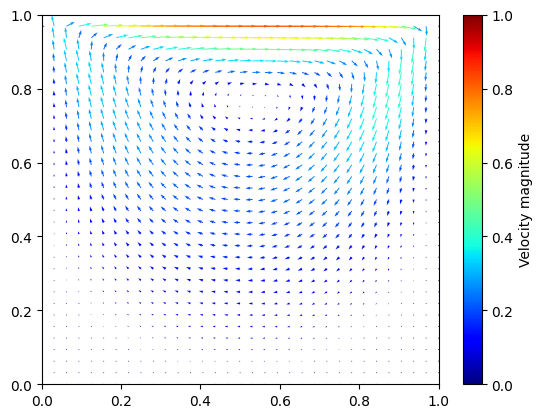

In [17]:
print("-----------------------------------")
print("        ONLINE PART                ")
print("-----------------------------------")
# Interpolate the reduced coefficient #
Ret=40.0 #targeted parameter!
nu=1./Ret;

# Regression on the new parameter
onlineParameters = scalerParameter.transform(np.array(Ret).reshape(1,1))
Alphak = gpr.predict(np.array(nu).reshape(1,1))
Alphak = scalerCoefficients.inverse_transform(Alphak).reshape(NumberOfModes)

Alphak=Alphak.reshape(NumberOfModes)

uRebuilt = np.dot(Alphak, ReducedBasis) #PODI approximation!
uRebuilt+=AveragedSnapshots

visualize_velocity(mesh,uRebuilt)

In [18]:
print("------------------------------------")
print("      Approximation accuracy        ")
print("------------------------------------")
### Online Errors
print("Online Errors")

ExactSolution,pressure=SolveCavityProblem(Ret,FineMesh)  # true solution
print("Reynolds: " , Ret)

H10=vector_laplace.assemble(FineBasis['u'],nu=1)

velocity=ExactSolution.copy()
velocity-=AveragedSnapshots
TrueAlpha=velocity@(L2@ReducedBasis.transpose()) #true projection coefficient (onto the reduced space)
print("true coefficients:",TrueAlpha)
print("PODI coefficients:", Alphak)
TrueCompressedSolution = np.dot(TrueAlpha, ReducedBasis) 
ReconstructedCompressedSolution = np.dot(Alphak, ReducedBasis) 

TrueCompressedSolution+=AveragedSnapshots
ReconstructedCompressedSolution+=AveragedSnapshots #ReconstructedCompressedSolution = uRebuilt
    
norml2ExactSolution=np.sqrt(ExactSolution@(L2@ExactSolution)) # for relative errors
normh10ExactSolution=np.sqrt(ExactSolution@(H10@ExactSolution))

AbsErrRec=np.abs(ReconstructedCompressedSolution-ExactSolution)
AbsErrTrue=np.abs(TrueCompressedSolution-ExactSolution)

if norml2ExactSolution !=0 and normh10ExactSolution != 0:

    L2RelError=np.sqrt(AbsErrRec@L2@AbsErrRec)/norml2ExactSolution
    H10RelError=np.sqrt(AbsErrRec@H10@AbsErrRec)/normh10ExactSolution

    TrueL2RelError=np.sqrt(AbsErrTrue@L2@AbsErrTrue)/norml2ExactSolution
    TrueH10RelError=np.sqrt(AbsErrTrue@H10@AbsErrTrue)/normh10ExactSolution
    
else:
    L2RelError = np.linalg.norm(ReconstructedCompressedSolution-ExactSolution)
    TrueL2RelError = np.linalg.norm(TrueCompressedSolution-ExactSolution)
    
print("L2 compression relative error with true coefficients = ", TrueL2RelError)
print("H1 compression relative error with true coefficients = ", TrueH10RelError)
print("Online L2 relative compression error = ", L2RelError)
print("Online H1 relative compression error = ", H10RelError)


------------------------------------
      Approximation accuracy        
------------------------------------
Online Errors
Parameter nu: 0.025
Reynolds:  40.0
true coefficients: [ 0.09223745  0.02226261 -0.00070397  0.00262406]
PODI coefficients: [0.09399186 0.03254626 0.0049354  0.00012923]
L2 compression relative error with true coefficients =  0.00644991321413451
H1 compression relative error with true coefficients =  0.007270888691335297
Online L2 relative compression error =  0.047371716791088904
Online H1 relative compression error =  0.04101786094341483
